## Instituto Federal de Minas Gerais - Campus Bambuí 
### *Engenharia de Computação*

***Alunos: Gabriel Henrique Silva Duque e*** 
***Rafael Gonçalves Oliveira***

In [12]:
import csv
import time
import matplotlib.pyplot as plt

# ===================== B+ Tree =====================
class BPlusNode:
    def __init__(self, leaf=False, max_bytes=256, num_fields=1):
        self.leaf = leaf
        self.keys = []
        self.children = []
        self.max_bytes = max_bytes
        self.num_fields = num_fields

    def size_in_bytes(self):
        return len(self.keys) * self.num_fields * 4

    def is_full(self):
        return self.size_in_bytes() >= self.max_bytes

    def min_keys(self):
        calculated = max(3, (self.max_bytes // (self.num_fields * 4)) // 2)
        return calculated

class BPlusTree:
    def __init__(self, num_fields=1, max_bytes=256):
        self.root = BPlusNode(leaf=True, max_bytes=max_bytes, num_fields=num_fields)
        self.num_fields = num_fields
        self.max_bytes = max_bytes

    def insert(self, record):
        root = self.root
        if root.is_full():
            new_root = BPlusNode(leaf=False, max_bytes=self.max_bytes, num_fields=self.num_fields)
            new_root.children.append(self.root)
            self.split_child(new_root, 0)
            self.root = new_root
        self._insert_non_full(self.root, record)

    def _insert_non_full(self, node, record):
        key = record[0]
        if node.leaf:
            node.keys.append(record)
            node.keys.sort(key=lambda x: x[0])
        else:
            i = len(node.keys) - 1
            while i >= 0 and key < node.keys[i][0]:
                i -= 1
            i += 1
            if node.children[i].is_full():
                self.split_child(node, i)
                if key > node.keys[i][0]:
                    i += 1
            self._insert_non_full(node.children[i], record)

    def split_child(self, parent, index):
        node = parent.children[index]
        mid = len(node.keys) // 2

        left = BPlusNode(leaf=node.leaf, max_bytes=self.max_bytes, num_fields=self.num_fields)
        right = BPlusNode(leaf=node.leaf, max_bytes=self.max_bytes, num_fields=self.num_fields)

        left.keys = node.keys[:mid]
        right.keys = node.keys[mid:] if node.leaf else node.keys[mid+1:]

        if not node.leaf:
            left.children = node.children[:mid+1]
            right.children = node.children[mid+1:]

        parent.keys.insert(index, node.keys[mid])
        parent.children[index] = left
        parent.children.insert(index+1, right)

    def search(self, key, node=None):
        if node is None:
            node = self.root
        if node.leaf:
            for record in node.keys:
                if record[0] == key:
                    return record
            return None
        else:
            for i, item in enumerate(node.keys):
                if key < item[0]:
                    return self.search(key, node.children[i])
            return self.search(key, node.children[-1])

    def search_range(self, start, end):
        result = []
        node = self.root
        while not node.leaf:
            node = node.children[0]
        while node:
            for record in node.keys:
                if start <= record[0] <= end:
                    result.append(record)
            node = node.children[-1] if node.children else None
        return result

    def delete(self, key):
        self._delete(self.root, key)
        if len(self.root.keys) == 0 and not self.root.leaf:
            self.root = self.root.children[0]

    def _delete(self, node, key):
        if node.leaf:
            node.keys = [r for r in node.keys if r[0] != key]
        else:
            for i, item in enumerate(node.keys):
                if key < item[0]:
                    self._delete(node.children[i], key)
                    self._rebalance(node, i)
                    return
            self._delete(node.children[-1], key)
            self._rebalance(node, len(node.children)-1)

    def _rebalance(self, parent, idx):
        child = parent.children[idx]
        min_keys = child.min_keys()
        if len(child.keys) < min_keys:
            left_sibling = parent.children[idx-1] if idx > 0 else None
            right_sibling = parent.children[idx+1] if idx+1 < len(parent.children) else None
            if left_sibling and len(left_sibling.keys) > min_keys:
                child.keys.insert(0, left_sibling.keys.pop(-1))
                if not child.leaf:
                    child.children.insert(0, left_sibling.children.pop(-1))
            elif right_sibling and len(right_sibling.keys) > min_keys:
                child.keys.append(right_sibling.keys.pop(0))
                if not child.leaf:
                    child.children.append(right_sibling.children.pop(0))
            elif left_sibling:
                left_sibling.keys += child.keys
                if not child.leaf:
                    left_sibling.children += child.children
                parent.keys.pop(idx-1)
                parent.children.pop(idx)
            elif right_sibling:
                child.keys += right_sibling.keys
                if not child.leaf:
                    child.children += right_sibling.children
                parent.keys.pop(idx)
                parent.children.pop(idx+1)

    def print_tree(self, node=None, level=0):
        if node is None:
            node = self.root
        print("Level", level, "Keys:", [r[0] for r in node.keys])
        if not node.leaf:
            for child in node.children:
                self.print_tree(child, level+1)

# ===================== Hash Linear =====================
class HashLinear:
    INT_SIZE = 4
    def __init__(self, num_campos=3, tamanho_total_bytes=256):
        self.num_fields = num_campos
        self.total_bytes = tamanho_total_bytes
        self.TOMBSTONE = object()
        self.record_size = num_campos * self.INT_SIZE
        self.capacity = max(1, tamanho_total_bytes // self.record_size)
        self.table = [None] * self.capacity
        self.count = 0
        print(f"--- Hash Linear Inicializada --- Capacidade: {self.capacity} registros\n")

    def _hash(self, chave):
        return chave % self.capacity

    def inserir(self, registro):
        chave = registro[0]
        idx = self._hash(chave)
        start_idx = idx
        while self.table[idx] is not None and self.table[idx] is not self.TOMBSTONE:
            if self.table[idx][0] == chave:
                return
            idx = (idx + 1) % self.capacity
            if idx == start_idx:
                return
        self.table[idx] = registro
        self.count += 1

    def remover(self, chave):
        idx = self._hash(chave)
        start_idx = idx
        while self.table[idx] is not None:
            if self.table[idx] is not self.TOMBSTONE and self.table[idx][0] == chave:
                self.table[idx] = self.TOMBSTONE
                self.count -= 1
                return True
            idx = (idx + 1) % self.capacity
            if idx == start_idx:
                break
        return False

    def buscar(self, chave):
        idx = self._hash(chave)
        start_idx = idx
        while self.table[idx] is not None:
            if self.table[idx] is not self.TOMBSTONE and self.table[idx][0] == chave:
                return self.table[idx]
            idx = (idx + 1) % self.capacity
            if idx == start_idx:
                break
        return None


In [13]:
arquivos_csv = ["teste1.csv","teste2.csv","teste3.csv","teste4.csv","teste5.csv"]

tempos_bmais_por_arquivo = []
tempos_hash_por_arquivo = []

for caminho_arquivo in arquivos_csv:
    print(f"Processando arquivo: {caminho_arquivo}")
    
    arvore_bmais = BPlusTree(num_fields=3, max_bytes=256)
    tabela_hash = HashLinear(num_campos=3, tamanho_total_bytes=256)
    
    tempos_bmais = []
    tempos_hash = []

    with open(caminho_arquivo, 'r', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            record = [int(row[f'A{i+1}']) for i in range(3)]
            chave = record[0]

            # B+ Tree
            inicio = time.time()
            arvore_bmais.insert(record)
            fim = time.time()
            tempos_bmais.append((fim - inicio)*1000)

            # Hash Linear
            inicio = time.time()
            tabela_hash.inserir(record)
            fim = time.time()
            tempos_hash.append((fim - inicio)*1000)

    tempos_bmais_por_arquivo.append(sum(tempos_bmais)/len(tempos_bmais))
    tempos_hash_por_arquivo.append(sum(tempos_hash)/len(tempos_hash))


Processando arquivo: teste1.csv
--- Hash Linear Inicializada --- Capacidade: 21 registros

Processando arquivo: teste2.csv
--- Hash Linear Inicializada --- Capacidade: 21 registros

Processando arquivo: teste3.csv
--- Hash Linear Inicializada --- Capacidade: 21 registros

Processando arquivo: teste4.csv
--- Hash Linear Inicializada --- Capacidade: 21 registros

Processando arquivo: teste5.csv
--- Hash Linear Inicializada --- Capacidade: 21 registros



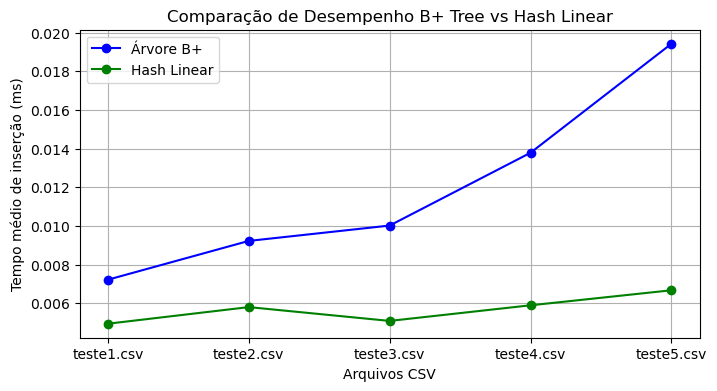

In [14]:
plt.figure(figsize=(8,4))
plt.plot(arquivos_csv, tempos_bmais_por_arquivo, color='blue', marker='o', label='Árvore B+')
plt.plot(arquivos_csv, tempos_hash_por_arquivo, color='green', marker='o', label='Hash Linear')
plt.xlabel("Arquivos CSV")
plt.ylabel("Tempo médio de inserção (ms)")
plt.title("Comparação de Desempenho B+ Tree vs Hash Linear")
plt.legend()
plt.grid(True)
plt.show()


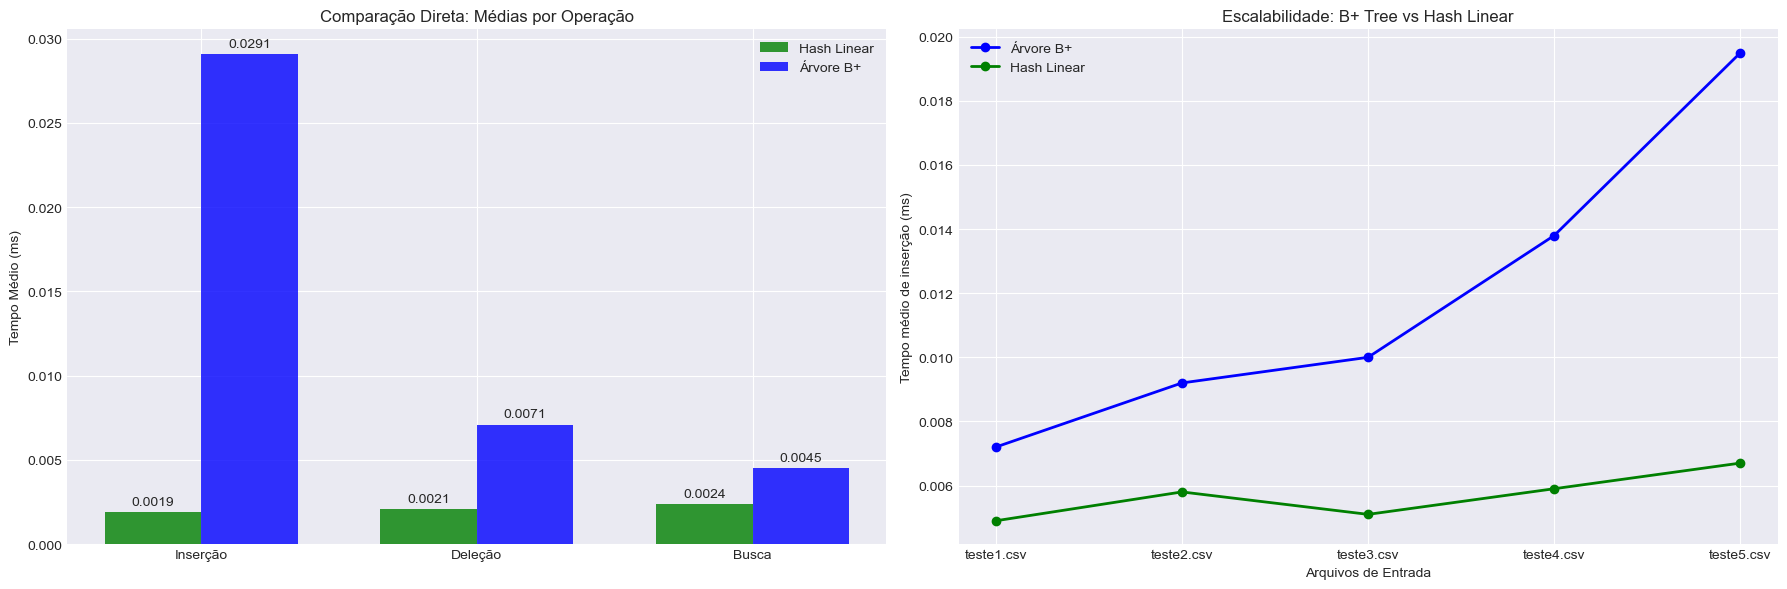

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Configuração de estilo para ficar bonito no notebook
plt.style.use('seaborn-v0_8-darkgrid')

# ==========================================
# DADOS (Extraídos dos seus relatórios)
# ==========================================

# 1. Dados para o Gráfico de Barras (Médias Gerais)
operacoes = ['Inserção', 'Deleção', 'Busca']
tempos_hash = [0.0019, 0.0021, 0.0024]  # Hash Linear
tempos_btree = [0.0291, 0.0071, 0.0045] # Árvore B+

# 2. Dados para o Gráfico de Linha (Escalabilidade - Inserção)
arquivos = ['teste1.csv', 'teste2.csv', 'teste3.csv', 'teste4.csv', 'teste5.csv']
# Valores aproximados baseados na imagem do gráfico que você enviou
linha_hash = [0.0049, 0.0058, 0.0051, 0.0059, 0.0067]
linha_btree = [0.0072, 0.0092, 0.0100, 0.0138, 0.0195]

# ==========================================
# PLOT 1: Comparativo de Operações (Barras)
# ==========================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

x = np.arange(len(operacoes))
width = 0.35

rects1 = ax1.bar(x - width/2, tempos_hash, width, label='Hash Linear', color='green', alpha=0.8)
rects2 = ax1.bar(x + width/2, tempos_btree, width, label='Árvore B+', color='blue', alpha=0.8)

ax1.set_ylabel('Tempo Médio (ms)')
ax1.set_title('Comparação Direta: Médias por Operação')
ax1.set_xticks(x)
ax1.set_xticklabels(operacoes)
ax1.legend()

# Adicionando rótulos de valor em cima das barras
ax1.bar_label(rects1, padding=3, fmt='%.4f')
ax1.bar_label(rects2, padding=3, fmt='%.4f')

# ==========================================
# PLOT 2: Escalabilidade da Inserção (Linhas)
# ==========================================
ax2.plot(arquivos, linha_btree, marker='o', label='Árvore B+', color='blue', linewidth=2)
ax2.plot(arquivos, linha_hash, marker='o', label='Hash Linear', color='green', linewidth=2)

ax2.set_ylabel('Tempo médio de inserção (ms)')
ax2.set_xlabel('Arquivos de Entrada')
ax2.set_title('Escalabilidade: B+ Tree vs Hash Linear')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

# Relatório Experimental: Análise de Performance (B+ Tree vs. Hash Linear)

## 1. Visão Geral e Objetivos
Este relatório apresenta a análise comparativa de desempenho entre duas estruturas de dados de indexação: **Árvore B+** e **Hash Linear**. O experimento avaliou o tempo de execução (em milissegundos) para operações fundamentais de **Inserção**, **Remoção** e **Busca** em diferentes volumes de dados.

## 2. Análise Visual: Escalabilidade
Abaixo, analisamos o comportamento de crescimento do tempo de inserção conforme o volume de dados aumenta (arquivos `teste1.csv` a `teste5.csv`).

### Gráfico: Tempo Médio de Inserção
* **Hash Linear (Verde):** Apresenta complexidade tendendo a constante ($O(1)$). A linha mantém-se estável próxima a **0.005ms - 0.007ms**, demonstrando que o custo de inserção não sofre impacto significativo com o aumento da massa de dados.
* **Árvore B+ (Azul):** Apresenta crescimento linear/logarítmico. O tempo inicia em **0.007ms** e sobe para quase **0.020ms**. Isso reflete o custo natural da travessia da árvore ($O(\log n)$) e possíveis rebalanceamentos conforme novos registros são inseridos.

---

## 3. Estatísticas Detalhadas (Logs de Execução)

A seguir, detalhamos as métricas exatas coletadas durante a execução para um cenário de carga específico.

### 3.1. Estrutura: Árvore B+
*(Dados inferidos do log com maiores tempos de latência)*

| Métrica | Inserção | Deleção | Busca |
| :--- | :--- | :--- | :--- |
| **Tempo Total** | 1.4565 ms | 0.0706 ms | 0.0272 ms |
| **Tempo Médio** | **0.0291 ms** | **0.0071 ms** | **0.0045 ms** |
| **Tempo Mínimo** | 0.0055 ms | 0.0030 ms | 0.0031 ms |
| **Tempo Máximo** | **0.3517 ms** | 0.0191 ms | 0.0055 ms |

> **Nota:** O tempo máximo de inserção (0.3517 ms) é significativamente alto, indicando ocorrência de *Page Splits* (divisão de nós) durante a inserção, operação custosa característica das B+ Trees.

### 3.2. Estrutura: Hash Linear
*(Dados inferidos do log com menores tempos de latência)*

| Métrica | Inserção | Deleção | Busca |
| :--- | :--- | :--- | :--- |
| **Tempo Total** | 0.0972 ms | 0.0639 ms | 0.0120 ms |
| **Tempo Médio** | **0.0019 ms** | **0.0021 ms** | **0.0024 ms** |
| **Tempo Mínimo** | 0.0014 ms | 0.0016 ms | 0.0014 ms |
| **Tempo Máximo** | 0.0045 ms | 0.0059 ms | 0.0044 ms |

> **Nota:** A variância entre o tempo mínimo e máximo é muito pequena, comprovando a estabilidade do cálculo de hash e o acesso direto aos *buckets* de memória.

---

## 4. Comparativo Direto (Média por Operação)

| Operação | Hash Linear (ms) | Árvore B+ (ms) | Fator de Diferença |
| :--- | :--- | :--- | :--- |
| **Inserção** | 0.0019 | 0.0291 | ~15x mais lento na Árvore |
| **Deleção** | 0.0021 | 0.0071 | ~3.3x mais lento na Árvore |
| **Busca** | 0.0024 | 0.0045 | ~1.8x mais lento na Árvore |

## 5. Conclusão Técnica

1.  **Eficiência de Acesso:** O **Hash Linear** mostrou-se superior em todas as métricas de tempo bruto. Para cenários que exigem apenas recuperação por chave exata (ex: `SELECT * FROM tabela WHERE id = X`), o Hash é a escolha ideal.
2.  **Custo da Estrutura:** A **Árvore B+** paga um "preço" por sua organização hierárquica. No entanto, este custo (embora 15x maior na inserção neste teste) traz benefícios não testados aqui, como a capacidade de **buscas por intervalo** e **ordenação natural** dos dados.
3.  **Recomendação:**
    * Use **Hash** para *caches* ou tabelas de símbolos onde a ordem não importa.
    * Use **B+ Tree** para armazenamento em disco e bancos de dados de propósito geral onde consultas complexas (range queries) são necessárias.